<a href="https://colab.research.google.com/github/LGLV-Ciencia-de-Datos/Paclobutrazol_like-ML/blob/main/Fusarium_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <a name='0'></a>
# **Instalación e importación de librerías**

In [ ]:
from IPython.utils import io
import tqdm.notebook
import os, sys, random, subprocess, statistics
total = 100
with tqdm.notebook.tqdm(total=total) as pbar:
    with io.capture_output() as captured:
        pbar.update(20)
        !pip install rdkit, pandas
        !pip install datamol # Biblioteca que proporciona utilidades y funciones para trabajar con datos moleculares, como moléculas químicas y conjuntos de datos químicos.
        !pip install molfeat # Centro de generadores de características moleculares.
        !pip install numpy
        !pip install sklearn #Biblioteca de ML, proporciona herramientas para realizar tareas comunes: clasificación, regresión, clustering y selección de modelos.
        !pip install yellowbrick #Biblioteca para visualización de ML
        pbar.update(30)
        import pandas as pd
        import datamol as dm
        from molfeat.calc import FPCalculator #Esta clase se utiliza para calcular descriptores moleculares
        from molfeat.trans import MoleculeTransformer # Esta clase se utiliza para transformar las moléculas aplicando ciertas operaciones.
        from molfeat.calc import FP_FUNCS #Esta clase se utiliza para calcular fingerprints
        pbar.update(30)
        import numpy as np
        from sklearn.model_selection import train_test_split #Se utiliza para dividir un conjunto de datos en conjuntos de entrenamiento y prueba.
        from sklearn.ensemble import HistGradientBoostingRegressor # Es una implementación de Gradient Boosting para problemas de regresión en scikit-learn.
        from yellowbrick.regressor import prediction_error, residuals_plot # Se utiliza para (1) visualizar y (2) gráficar errores de predicción en problemas de regresión.
        #RDKit
        !pip install rdkit
        from rdkit import Chem, DataStructs
        from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors, Descriptors3D, rdMolDescriptors, Scaffolds
        PandasTools.RenderImagesInAllDataFrames(images=True) #Para visualizar moléculas
        from rdkit.Chem.Draw import IPythonConsole

        pbar.update(20)

  0%|          | 0/100 [00:00<?, ?it/s]

<a name='1'></a>
##**1.** Lectura de archivos.
Se leerá el archivo (csv o xlsx) que cuente con la información de las moléculas de interés (SMILES, ID/NAME, propiedad).

Ejemplo:
```
filename ="https://raw.githubusercontent.com/PatWalters/yamc/main/data/Carbonic.smi"
df = pd.read_csv(filename,sep=" ",names=["SMILES","Name","pIC50"])
```


In [ ]:
#Leer archivo
url = "https://raw.githubusercontent.com/LGLV-Ciencia-de-Datos/Paclobutrazol_like-ML/refs/heads/main/FO_for_ML.csv"
data = pd.read_csv(url, index_col=0)
data

,molecule_chembl_id,canonical_smiles,standard_value,standard_units,target_chembl_id,target_organism,MW,LogP,HBA,HBD,...,logP,TPSA,CSP3,NumRings,HetAtoms,RotBonds,Molecule,QED,SA,Dataset
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
2,CHEMBL393258,COc1cc(O)cc2c1C(=O)O[C@@H](C)CCCCCCC2,100.00,ug.mL-1,CHEMBL612648,Fusarium oxysporum,292.167459,3.84280,4,1,...,3.84280,55.76,0.588235,2,4,1,<rdkit.Chem.rdchem.Mol object at 0x7a2419f2f4c0>,0.798916,3.168201,Fusarium oxysporum
3,CHEMBL211893,CC1CCCCCCCc2cc(O)cc(O)c2C(=O)O1,50.00,ug.mL-1,CHEMBL612648,Fusarium oxysporum,278.151809,3.53980,4,2,...,3.53980,66.76,0.562500,2,4,0,<rdkit.Chem.rdchem.Mol object at 0x7a2419f2f140>,0.712264,3.199496,Fusarium oxysporum
4,CHEMBL213981,CC1CC(O)CCCCCc2cc(O)cc(O)c2C(=O)O1,100.00,ug.mL-1,CHEMBL612648,Fusarium oxysporum,294.146724,2.51060,5,3,...,2.51060,86.99,0.562500,2,5,0,<rdkit.Chem.rdchem.Mol object at 0x7a2419f2e810>,0.639962,3.663886,Fusarium oxysporum
5,CHEMBL265003,COc1cc(OC(C)=O)cc2c1C(=O)OC(C)CCCCCCC2,100.00,ug.mL-1,CHEMBL612648,Fusarium oxysporum,334.178024,4.06250,5,0,...,4.06250,61.83,0.578947,2,5,2,<rdkit.Chem.rdchem.Mol object at 0x7a2419f2f840>,0.602666,3.201180,Fusarium oxysporum
6,CHEMBL377185,COc1c(Br)c(O)c(Br)c2c1C(=O)OC(C)CCCCCCC2,12.50,ug.mL-1,CHEMBL612648,Fusarium oxysporum,447.988483,5.36780,4,1,...,5.36780,55.76,0.588235,2,6,1,<rdkit.Chem.rdchem.Mol object at 0x7a2419f2fca0>,0.585330,3.613405,Fusarium oxysporum
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,CHEMBL5274211,C/C(=C\[C@@H](O)C/C(C)=C/CCc1ccoc1)C/C=C/c1ccoc1,1.00,ug.mL-1,CHEMBL612648,Fusarium oxysporum,326.188195,5.55230,3,1,...,5.55230,46.51,0.333333,2,3,9,<rdkit.Chem.rdchem.Mol object at 0x7a2419dc18c0>,0.614276,3.856005,Fusarium oxysporum
882,CHEMBL5425430,NC(Cc1c[nH]c2ccccc12)C(=O)Oc1ccc2c(=O)c3ccccc3...,20.00,ug.mL-1,CHEMBL612648,Fusarium oxysporum,398.126657,3.90290,5,2,...,3.90290,98.32,0.083333,5,6,4,<rdkit.Chem.rdchem.Mol object at 0x7a2419dc19a0>,0.271755,2.738239,Fusarium oxysporum
885,CHEMBL5415519,Cc1ccc(S(=O)(=O)NC(=S)Nc2nnc(C)s2)cc1,25.00,ug.mL-1,CHEMBL612648,Fusarium oxysporum,328.012239,1.83024,6,2,...,1.83024,83.98,0.181818,2,9,3,<rdkit.Chem.rdchem.Mol object at 0x7a2419dc1b60>,0.836437,2.263413,Fusarium oxysporum


In [ ]:
data.columns

Index(['molecule_chembl_id', 'canonical_smiles', 'standard_value',
       'standard_units', 'target_chembl_id', 'target_organism', 'MW', 'LogP',
       'HBA', 'HBD', 'RotatableBonds', 'violations', 'uM', 'pMIC_ug/mL-1',
       'pMIC_uM', 'NEW_SMILES', 'ROMol', 'logP', 'TPSA', 'CSP3', 'NumRings',
       'HetAtoms', 'RotBonds', 'Molecule', 'QED', 'SA', 'Dataset'],
      dtype='object')

In [ ]:
df = data[['molecule_chembl_id', 	'NEW_SMILES', 	'pMIC_uM']]
df

,molecule_chembl_id,NEW_SMILES,pMIC_uM
Unnamed: 0,,,
2,CHEMBL393258,COc1cc(O)cc2c1C(=O)O[C@@H](C)CCCCCCC2,-2.534060
3,CHEMBL211893,CC1CCCCCCCc2cc(O)cc(O)c2C(=O)O1,-2.254382
4,CHEMBL213981,CC1CC(O)CCCCCc2cc(O)cc(O)c2C(=O)O1,-2.531140
5,CHEMBL265003,COc1cc(OC(C)=O)cc2c1C(=O)OC(C)CCCCCCC2,-2.475718
6,CHEMBL377185,COc1c(Br)c(O)c(Br)c2c1C(=O)OC(C)CCCCCCC2,-1.443536
...,...,...,...
871,CHEMBL5274211,C/C(=C\[C@@H](O)C/C(C)=C/CCc1ccoc1)C/C=C/c1ccoc1,-0.486202
882,CHEMBL5425430,NC(Cc1c[nH]c2ccccc12)C(=O)Oc1ccc2c(=O)c3ccccc3...,-1.700691
885,CHEMBL5415519,Cc1ccc(S(=O)(=O)NC(=S)Nc2nnc(C)s2)cc1,-1.881479


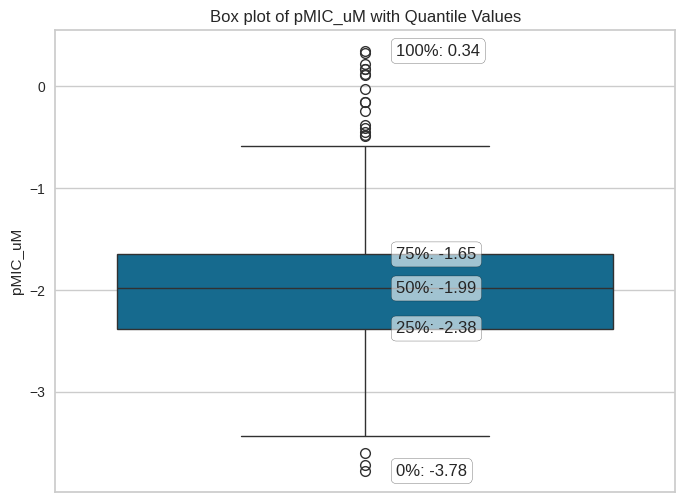

In [ ]:
# prompt: plot box of pMIC_uM show thequantile values in the plot

import matplotlib.pyplot as plt
import seaborn as sns

# Calculate quantiles
quantiles = df['pMIC_uM'].quantile([0, 0.25, 0.5, 0.75, 1])

# Create the box plot
plt.figure(figsize=(8, 6))
sns.boxplot(y=df['pMIC_uM'])
plt.ylabel('pMIC_uM')
plt.title('Box plot of pMIC_uM with Quantile Values')

# Add text annotations for quantile values
for i, quantile_value in enumerate(quantiles):
    plt.text(0.05, quantile_value, f'{quantiles.index[i]*100:.0f}%: {quantile_value:.2f}',
             horizontalalignment='left', verticalalignment='center',
             bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.6))

plt.show()


,molecule_chembl_id,NEW_SMILES,pMIC_uM,ROMol
Unnamed: 0,,,,
2,CHEMBL393258,COc1cc(O)cc2c1C(=O)O[C@@H](C)CCCCCCC2,-2.534060,
3,CHEMBL211893,CC1CCCCCCCc2cc(O)cc(O)c2C(=O)O1,-2.254382,
4,CHEMBL213981,CC1CC(O)CCCCCc2cc(O)cc(O)c2C(=O)O1,-2.531140,

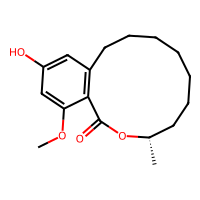
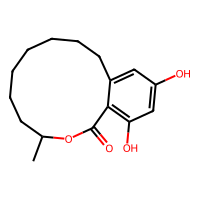
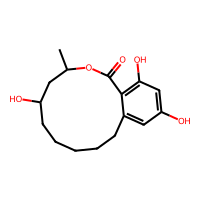

In [ ]:
df_visualization=df.copy()
df_visualization['ROMol'] = df_visualization['NEW_SMILES'].apply(Chem.MolFromSmiles)
df_visualization[0:3]

<a name='2'></a>
## **2.** Selección de descriptores.
Se emplea el paquete [molfeat](https://github.com/datamol-io/molfeat), el cual tiene varios tipos de descriptores disponibles.

In [ ]:
print(f'Fingerprints que se puenden calcular:') #Descriptores que se pueden calcular con esta libreria
for i in FP_FUNCS:
    print(i)

Fingerprints que se puenden calcular:
maccs
avalon
pattern
layered
map4
secfp
erg
estate
avalon-count
ecfp
fcfp
topological
atompair
rdkit
ecfp-count
fcfp-count
topological-count
atompair-count
rdkit-count


In [ ]:
calc_ecfp = FPCalculator("ecfp") #Cálculo de ECFP4
calc_maccs = FPCalculator("maccs")

<a name='3'></a>

##**3.** Transformación de moléculas (molfeat).

Este objeto toma una lista de SMILES como input y regresa los descriptores seleccionados. Es muy flexible y puede correr en paralelo.[URL](https://molfeat-docs.datamol.io/stable/tutorials/types_of_featurizers.html)

In [ ]:
trans_ecfp = MoleculeTransformer(calc_ecfp)
trans_maccs = MoleculeTransformer(calc_maccs)

<a name='4'></a>

## **4.** Cálculo de fingerprints.
Tenga en cuenta el uso de la función [datamol](https://datamol.io), que silencia el registro de mensajes del RDKit. Esta es una versión más amigable de la función rd_shut_the_hell_up en [useful_rdkit_utils](https://github.com/PatWalters/useful_rdkit_utils).

In [ ]:
%%time
with dm.without_rdkit_log():
    df['fp_ecfp'] = trans_ecfp.transform(df.NEW_SMILES.values)
    df['fp_maccs'] = trans_maccs.transform(df.NEW_SMILES.values)

print(df.shape)
df

<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(580, 5)
CPU times: user 777 ms, sys: 9.91 ms, total: 787 ms
Wall time: 792 ms


<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,molecule_chembl_id,NEW_SMILES,pMIC_uM,fp_ecfp,fp_maccs
Unnamed: 0,,,,,
2,CHEMBL393258,COc1cc(O)cc2c1C(=O)O[C@@H](C)CCCCCCC2,-2.534060,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CHEMBL211893,CC1CCCCCCCc2cc(O)cc(O)c2C(=O)O1,-2.254382,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CHEMBL213981,CC1CC(O)CCCCCc2cc(O)cc(O)c2C(=O)O1,-2.531140,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,CHEMBL265003,COc1cc(OC(C)=O)cc2c1C(=O)OC(C)CCCCCCC2,-2.475718,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,CHEMBL377185,COc1c(Br)c(O)c(Br)c2c1C(=O)OC(C)CCCCCCC2,-1.443536,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
871,CHEMBL5274211,C/C(=C\[C@@H](O)C/C(C)=C/CCc1ccoc1)C/C=C/c1ccoc1,-0.486202,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
882,CHEMBL5425430,NC(Cc1c[nH]c2ccccc12)C(=O)Oc1ccc2c(=O)c3ccccc3...,-1.700691,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
885,CHEMBL5415519,Cc1ccc(S(=O)(=O)NC(=S)Nc2nnc(C)s2)cc1,-1.881479,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


580

<a name='5'></a>
##**5.** Segmentación de datos: entrenamiento y prueba.
Es buena opción realizar con dataframes, ya que de esta manera no tienes que recordar el orden en que se recupera la información (entrenamiento_x, prueba_x,entrenamiento_y y prueba_y) con [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [ ]:
train, test = train_test_split(df, test_size=0.3, train_size=0.7, random_state=1) #Métrica común 70:30
train

,molecule_chembl_id,NEW_SMILES,pMIC_uM,fp_ecfp,fp_maccs
Unnamed: 0,,,,,
522,CHEMBL2262381,COc1ccc2cc(/C=N/NC(=O)C3=C(O)c4ccccc4S(=O)(=O)...,-3.325222,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
612,CHEMBL2334107,CCOC(=O)c1c2[nH]c(=N)c3ccccc3c2nn1-c1ccc(C)cc1,-2.159405,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
621,CHEMBL2334116,COc1ccc(C2C(C#N)c3ccccc3C(=N)C2(C#N)C#N)cc1,-2.185274,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
267,CHEMBL1241537,O=C(Cn1ncc2cc([N+](=O)[O-])ccc21)N/N=C/c1ccccc1,-1.720827,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
653,CHEMBL2435145,CC(C)c1cc(=O)n2c3ccccc3n(Cc3cc(=O)oc4ccc(Cl)cc...,0.322083,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
254,CHEMBL1241817,O=C(Cn1ncc2cc([N+](=O)[O-])ccc21)N/N=C/c1cccc(...,-1.475180,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
269,CHEMBL1241903,COc1ccc(/C=N/NC(=O)Cn2ncc3cc([N+](=O)[O-])ccc3...,-1.707082,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
161,CHEMBL573954,Nc1ncc(C(=O)Nc2nc3ccccc3s2)c(N)n1,-1.339028,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
test

,molecule_chembl_id,NEW_SMILES,pMIC_uM,fp_ecfp,fp_maccs
Unnamed: 0,,,,,
517,CHEMBL2262821,Nc1ccc(C(=O)NN=C2C3CCCC2C(c2ccc(F)cc2)NC3c2ccc...,-2.035714,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
440,CHEMBL2159590,C=CCN1[C@H](c2ccccc2)C/C(=N\OCc2ccccc2)[C@@H](...,-1.769972,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
137,CHEMBL499738,CC(C)(C)OC(=O)N1CCC(n2cc(C(N)=O)nn2)CC1,-2.270036,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
556,CHEMBL508690,O=c1c2ccccc2nc(/C=C/c2ccccc2)n1-c1nnc(-c2ccc(C...,-1.581808,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
841,CHEMBL4526926,Oc1ccc(Br)cc1C1=NNC(c2cc3ccccc3n3nnnc23)C1,-1.785955,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...
411,CHEMBL2062836,Cc1ccc(/C=C/c2onc(C)c2-n2c(C)nc3nc4ccccc4cc3c2...,-1.468031,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
446,CHEMBL2159584,C=CCN1[C@H](c2ccccc2)C/C(=N\OCc2ccccc2)[C@@H](...,-2.687652,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
233,CHEMBL1242175,Nc1sc2c(c1C(=O)Nc1nc3ccccc3s1)CCCC2,-2.482210,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


<a name='6'></a>

##**6.** Regresión (sklearn).
En este caso se utilizó
[HistGradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.HistGradientBoostingRegressor.html)
que es la implementación scikit-learn de
[LightGBM](https://lightgbm.readthedocs.io/en/latest/Python-Intro.html)
. Puede conectar fácilmente cualquier regresor compatible con scikit-learn como [RandomForest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) o [XGBoost](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)



```
from lightgbm import LGBMRegressor
model = LGBMRegressor()
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()
from xgboost import XGBRegressor
model = XGBRegressor()
```



In [ ]:
# prompt: Crea 8 modelos de eregresión para e ntrenar este df con fp_ecfp 	fp_maccs, fija la relacion 70:30 entrenamiento y prueba, y dame los rerultados en u  DF y dime cual es el que dio el mejor rendimiento

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Define the target variable and features
y_train = train.pMIC_uM
y_test = test.pMIC_uM

X_train_ecfp = np.stack(train.fp_ecfp.values)
X_test_ecfp = np.stack(test.fp_ecfp.values)

X_train_maccs = np.stack(train.fp_maccs.values)
X_test_maccs = np.stack(test.fp_maccs.values)


# Define the models
models = {
    "Linear Regression (ECFP)": LinearRegression(),
    "Ridge Regression (ECFP)": Ridge(),
    "Lasso Regression (ECFP)": Lasso(),
    "Elastic Net (ECFP)": ElasticNet(),
    "Random Forest (ECFP)": RandomForestRegressor(random_state=1),
    "Gradient Boosting (ECFP)": GradientBoostingRegressor(random_state=1),
    "Decision Tree (ECFP)": DecisionTreeRegressor(random_state=1),
    "SVR (ECFP)": SVR(),
    "HistGradientBoostingRegressor (ECFP)": HistGradientBoostingRegressor(),

    "Linear Regression (MACCS)": LinearRegression(),
    "Ridge Regression (MACCS)": Ridge(),
    "Lasso Regression (MACCS)": Lasso(),
    "Elastic Net (MACCS)": ElasticNet(),
    "Random Forest (MACCS)": RandomForestRegressor(random_state=1),
    "Gradient Boosting (MACCS)": GradientBoostingRegressor(random_state=1),
    "Decision Tree (MACCS)": DecisionTreeRegressor(random_state=1),
    "SVR (MACCS)": SVR(),
    "HistGradientBoostingRegressor (MACCS)": HistGradientBoostingRegressor(),

}

results = []

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    if "(ECFP)" in name:
        model.fit(X_train_ecfp, y_train)
        y_pred = model.predict(X_test_ecfp)
    elif "(MACCS)" in name:
        model.fit(X_train_maccs, y_train)
        y_pred = model.predict(X_test_maccs)
    else:
        continue # Skip if not ECFP or MACCS

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MSE": mse, "R2": r2})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Find the best performing model based on R2 score
best_model = results_df.loc[results_df['R2'].idxmax()]

print("\nRegression Model Results:")
print(results_df)

print("\nBest Performing Model (based on R2):")
best_model



Training Linear Regression (ECFP)...
Training Ridge Regression (ECFP)...
Training Lasso Regression (ECFP)...
Training Elastic Net (ECFP)...
Training Random Forest (ECFP)...
Training Gradient Boosting (ECFP)...
Training Decision Tree (ECFP)...
Training SVR (ECFP)...
Training HistGradientBoostingRegressor (ECFP)...
Training Linear Regression (MACCS)...
Training Ridge Regression (MACCS)...
Training Lasso Regression (MACCS)...
Training Elastic Net (MACCS)...
Training Random Forest (MACCS)...
Training Gradient Boosting (MACCS)...
Training Decision Tree (MACCS)...
Training SVR (MACCS)...
Training HistGradientBoostingRegressor (MACCS)...

Regression Model Results:
                                    Model       MSE        R2
0                Linear Regression (ECFP)  0.182180  0.565044
1                 Ridge Regression (ECFP)  0.152330  0.636309
2                 Lasso Regression (ECFP)  0.419148 -0.000722
3                      Elastic Net (ECFP)  0.419148 -0.000722
4                    Ran

,5
Model,Gradient Boosting (ECFP)
MSE,0.148398
R2,0.645698


In [ ]:
# prompt: Repite los modelos, eliminando las variables independientes que no son necesarias

import pandas as pd
import numpy as np
# Define the target variable and features
y_train = train.pMIC_uM
y_test = test.pMIC_uM

X_train_ecfp = np.stack(train.fp_ecfp.values)
X_test_ecfp = np.stack(test.fp_ecfp.values)

X_train_maccs = np.stack(train.fp_maccs.values)
X_test_maccs = np.stack(test.fp_maccs.values)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Define the models
models = {
    "Linear Regression (ECFP)": LinearRegression(),
    "Ridge Regression (ECFP)": Ridge(),
    "Lasso Regression (ECFP)": Lasso(),
    "Elastic Net (ECFP)": ElasticNet(),
    "Random Forest (ECFP)": RandomForestRegressor(random_state=1),
    "Gradient Boosting (ECFP)": GradientBoostingRegressor(random_state=1),
    "Decision Tree (ECFP)": DecisionTreeRegressor(random_state=1),
    "SVR (ECFP)": SVR(),
    "HistGradientBoostingRegressor (ECFP)": HistGradientBoostingRegressor(),

    "Linear Regression (MACCS)": LinearRegression(),
    "Ridge Regression (MACCS)": Ridge(),
    "Lasso Regression (MACCS)": Lasso(),
    "Elastic Net (MACCS)": ElasticNet(),
    "Random Forest (MACCS)": RandomForestRegressor(random_state=1),
    "Gradient Boosting (MACCS)": GradientBoostingRegressor(random_state=1),
    "Decision Tree (MACCS)": DecisionTreeRegressor(random_state=1),
    "SVR (MACCS)": SVR(),
    "HistGradientBoostingRegressor (MACCS)": HistGradientBoostingRegressor(),

}

results = []

# Train and evaluate each model
for name, model in models.items():
    print(f"Training {name}...")
    if "(ECFP)" in name:
        model.fit(X_train_ecfp, y_train)
        y_pred = model.predict(X_test_ecfp)
    elif "(MACCS)" in name:
        model.fit(X_train_maccs, y_train)
        y_pred = model.predict(X_test_maccs)
    else:
        continue # Skip if not ECFP or MACCS

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results.append({"Model": name, "MSE": mse, "R2": r2})

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Find the best performing model based on R2 score
best_model = results_df.loc[results_df['R2'].idxmax()]

print("\nRegression Model Results:")
print(results_df)

print("\nBest Performing Model (based on R2):")
best_model


Training Linear Regression (ECFP)...
Training Ridge Regression (ECFP)...
Training Lasso Regression (ECFP)...
Training Elastic Net (ECFP)...
Training Random Forest (ECFP)...
Training Gradient Boosting (ECFP)...
Training Decision Tree (ECFP)...
Training SVR (ECFP)...
Training HistGradientBoostingRegressor (ECFP)...
Training Linear Regression (MACCS)...
Training Ridge Regression (MACCS)...
Training Lasso Regression (MACCS)...
Training Elastic Net (MACCS)...
Training Random Forest (MACCS)...
Training Gradient Boosting (MACCS)...
Training Decision Tree (MACCS)...
Training SVR (MACCS)...
Training HistGradientBoostingRegressor (MACCS)...

Regression Model Results:
                                    Model       MSE        R2
0                Linear Regression (ECFP)  0.182180  0.565044
1                 Ridge Regression (ECFP)  0.152330  0.636309
2                 Lasso Regression (ECFP)  0.419148 -0.000722
3                      Elastic Net (ECFP)  0.419148 -0.000722
4                    Ran

,5
Model,Gradient Boosting (ECFP)
MSE,0.148398
R2,0.645698


In [ ]:
model = HistGradientBoostingRegressor()


Visualizing errors for Linear Regression (ECFP)...


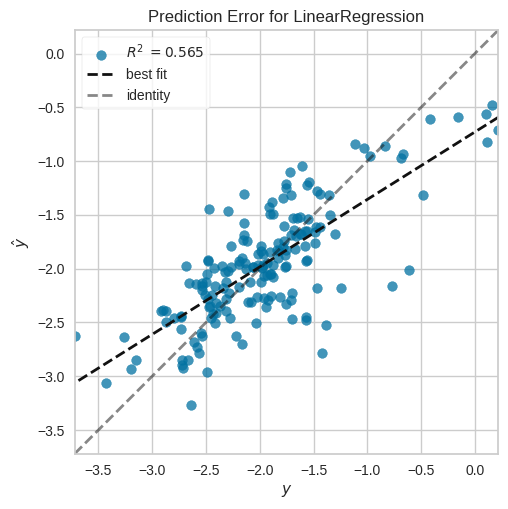

<Figure size 800x550 with 0 Axes>


Visualizing errors for Ridge Regression (ECFP)...


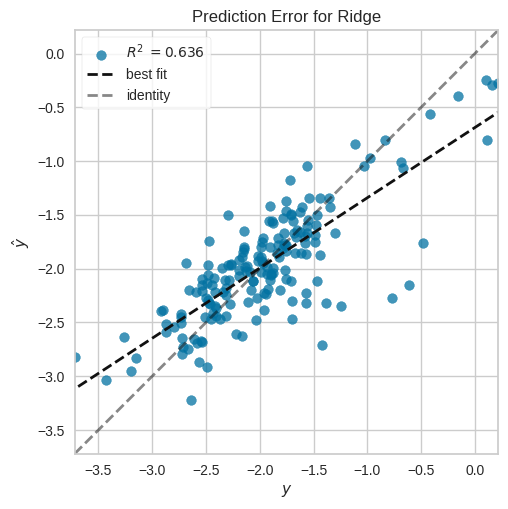

<Figure size 800x550 with 0 Axes>


Visualizing errors for Lasso Regression (ECFP)...


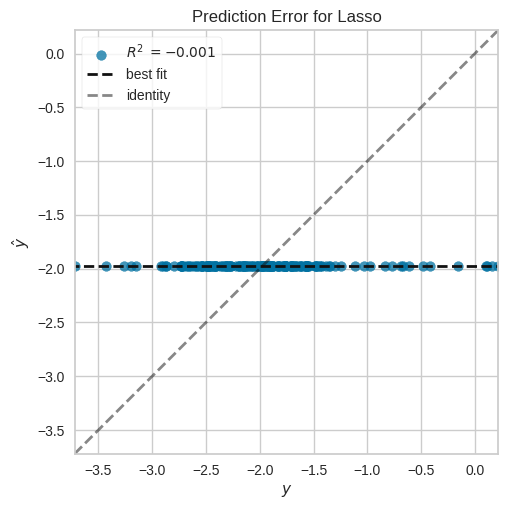

<Figure size 800x550 with 0 Axes>


Visualizing errors for Elastic Net (ECFP)...


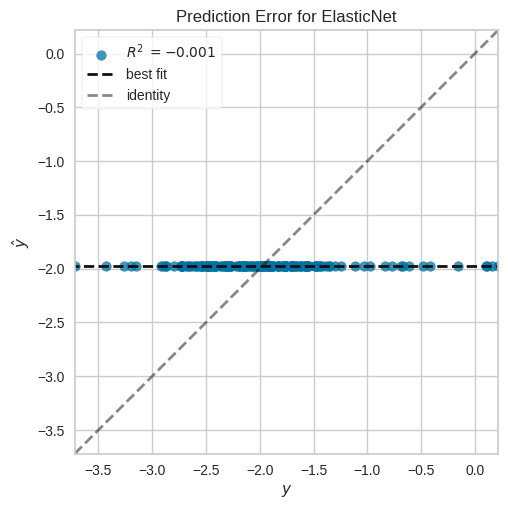

<Figure size 800x550 with 0 Axes>


Visualizing errors for Random Forest (ECFP)...


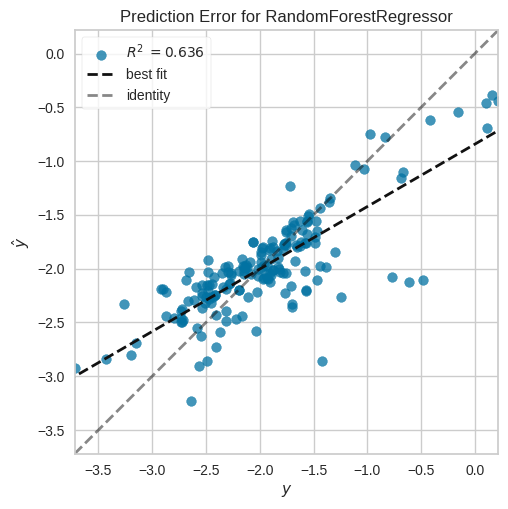

<Figure size 800x550 with 0 Axes>


Visualizing errors for Gradient Boosting (ECFP)...


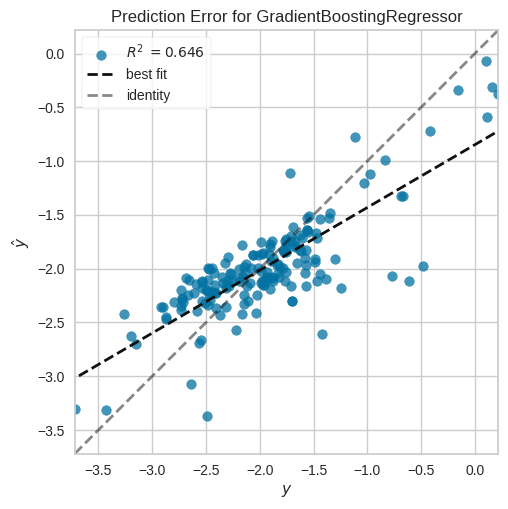

<Figure size 800x550 with 0 Axes>


Visualizing errors for Decision Tree (ECFP)...


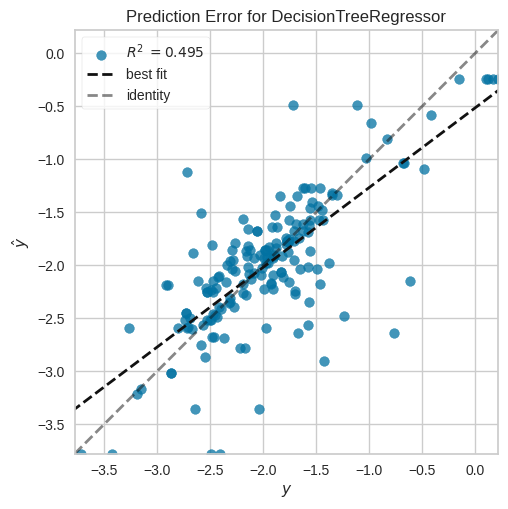

<Figure size 800x550 with 0 Axes>


Visualizing errors for SVR (ECFP)...


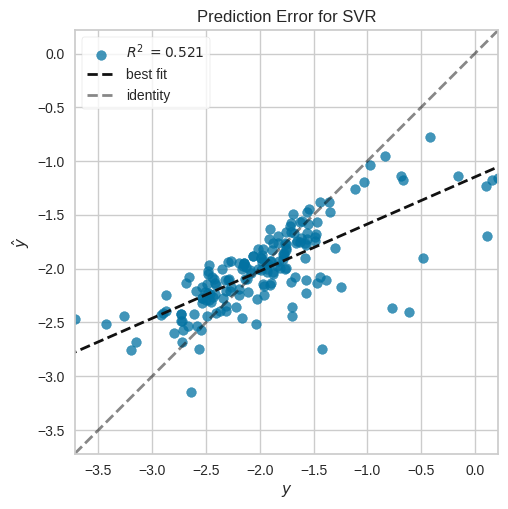

<Figure size 800x550 with 0 Axes>


Visualizing errors for HistGradientBoostingRegressor (ECFP)...


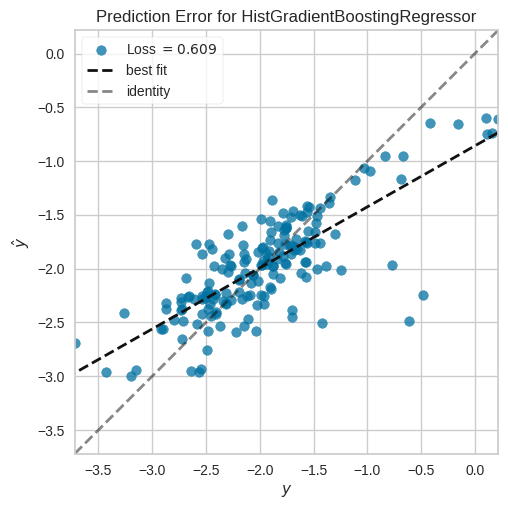

<Figure size 800x550 with 0 Axes>


Visualizing errors for Linear Regression (MACCS)...


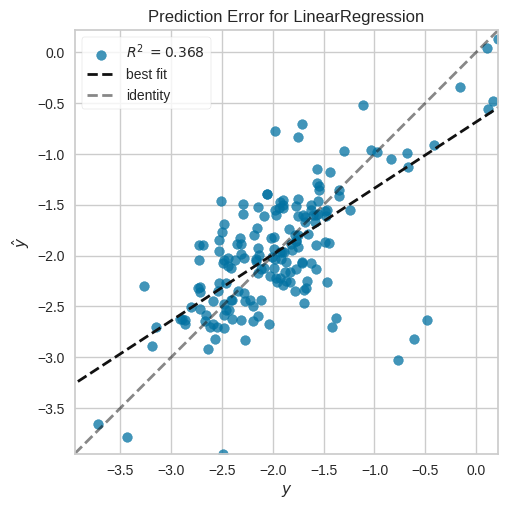

<Figure size 800x550 with 0 Axes>


Visualizing errors for Ridge Regression (MACCS)...


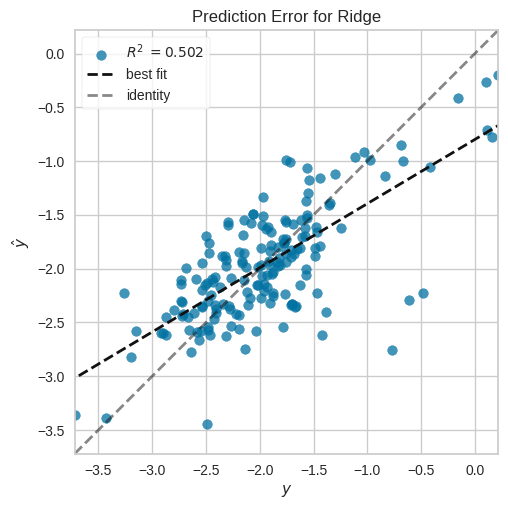

<Figure size 800x550 with 0 Axes>


Visualizing errors for Lasso Regression (MACCS)...


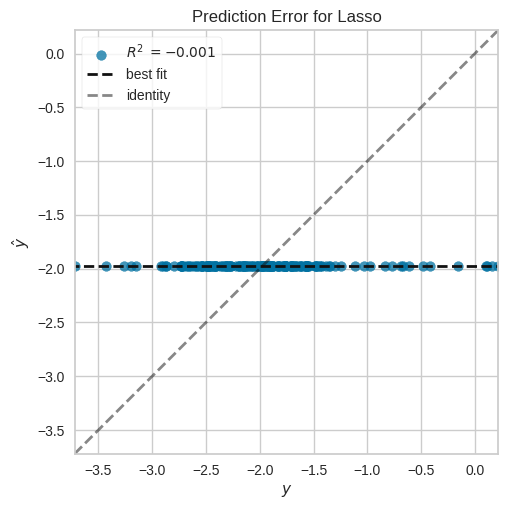

<Figure size 800x550 with 0 Axes>


Visualizing errors for Elastic Net (MACCS)...


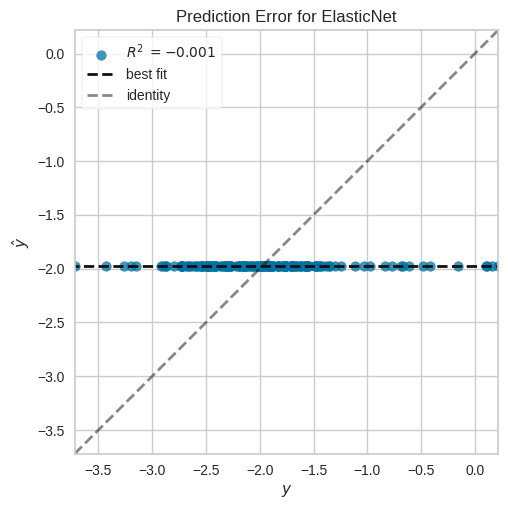

<Figure size 800x550 with 0 Axes>


Visualizing errors for Random Forest (MACCS)...


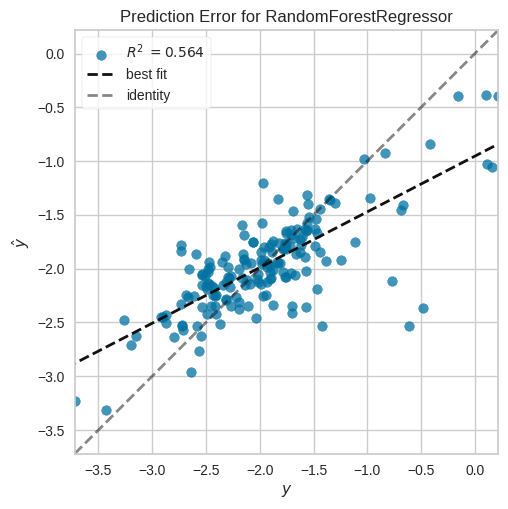

<Figure size 800x550 with 0 Axes>


Visualizing errors for Gradient Boosting (MACCS)...


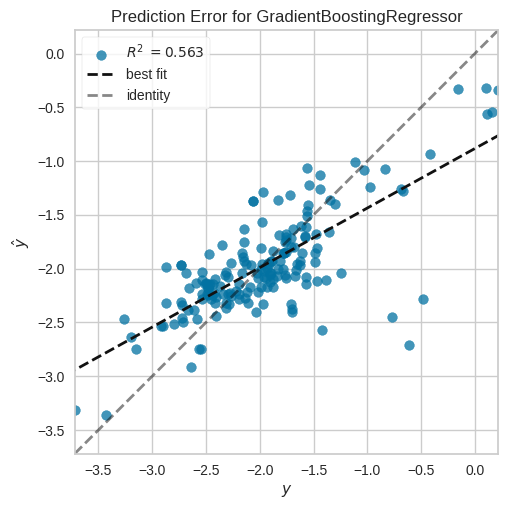

<Figure size 800x550 with 0 Axes>


Visualizing errors for Decision Tree (MACCS)...


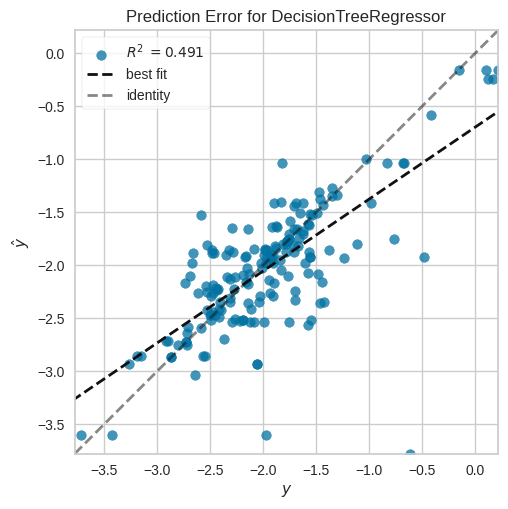

<Figure size 800x550 with 0 Axes>


Visualizing errors for SVR (MACCS)...


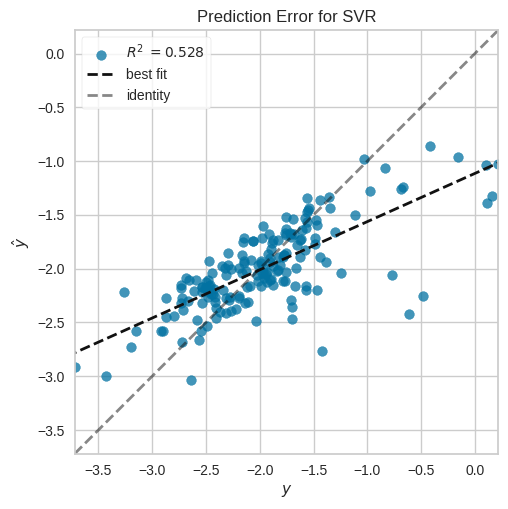

<Figure size 800x550 with 0 Axes>


Visualizing errors for HistGradientBoostingRegressor (MACCS)...


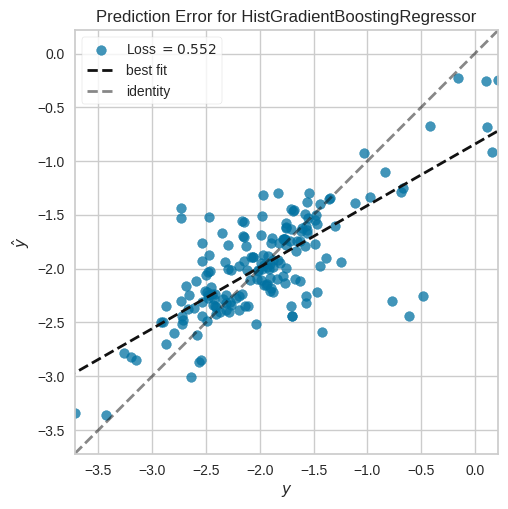

<Figure size 800x550 with 0 Axes>

In [ ]:
# prompt: adapata este codigo para visualizar los errores de los 8 modelos con los fingerprints elegidos: %%time
# visualizer = prediction_error(model,
#                               X_train=np.stack(train.fp_maccs), y_train=train.pMIC_uM,
#                               X_test=np.stack(test.fp_maccs), y_test=test.pMIC_uM)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# <a name='7'></a>
#
# ##**7.** Visualización de resultados (yellowbrick).
# Yellowbrick es una biblioteca de visualización de aprendizaje automático que extiende la biblioteca scikit-learn. El paquete yellowbrick es un excelente compañero de scikit-learn y te permite generar un diagrama que muestra visualmente el rendimiento de tus modelos.
#
#

# Visualizar los errores para cada modelo con cada fingerprint
for name, model in models.items():
    print(f"\nVisualizing errors for {name}...")
    if "(ECFP)" in name:
        visualizer = prediction_error(model,
                                      X_train=X_train_ecfp, y_train=y_train,
                                      X_test=X_test_ecfp, y_test=y_test)
        visualizer.fig.suptitle(f'Prediction Error Plot for {name}')
        visualizer.show()
    elif "(MACCS)" in name:
        visualizer = prediction_error(model,
                                      X_train=X_train_maccs, y_train=y_train,
                                      X_test=X_test_maccs, y_test=y_test)
        visualizer.fig.suptitle(f'Prediction Error Plot for {name}')
        visualizer.show()


Visualizing residuals for Linear Regression (ECFP)...


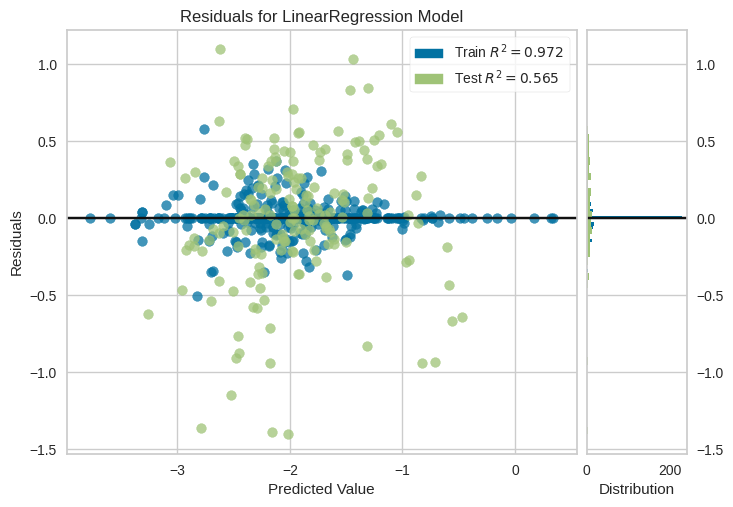

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Ridge Regression (ECFP)...


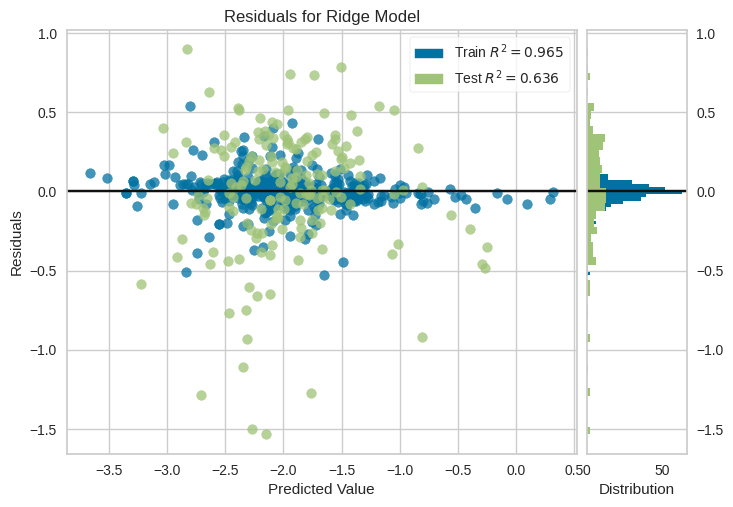

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Lasso Regression (ECFP)...


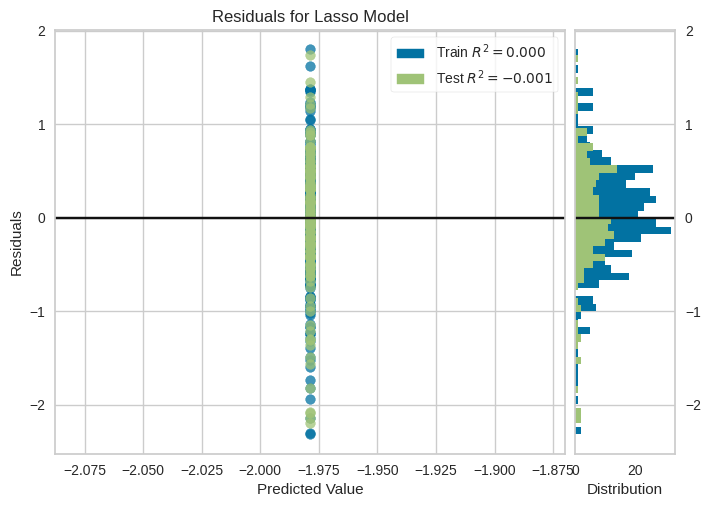

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Elastic Net (ECFP)...


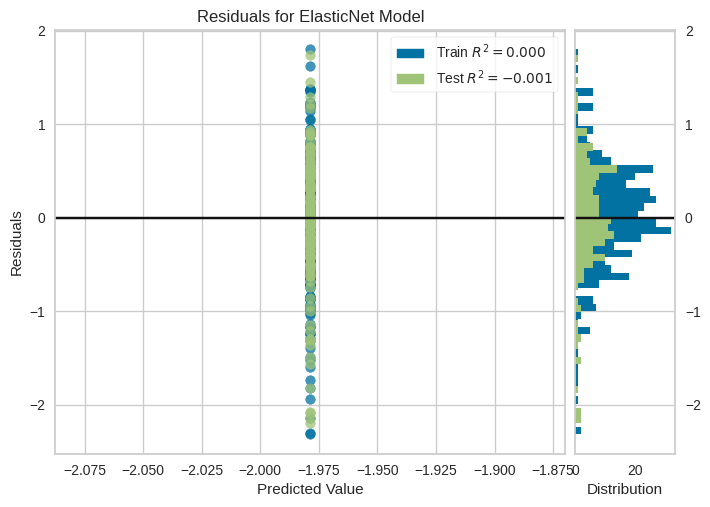

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Random Forest (ECFP)...


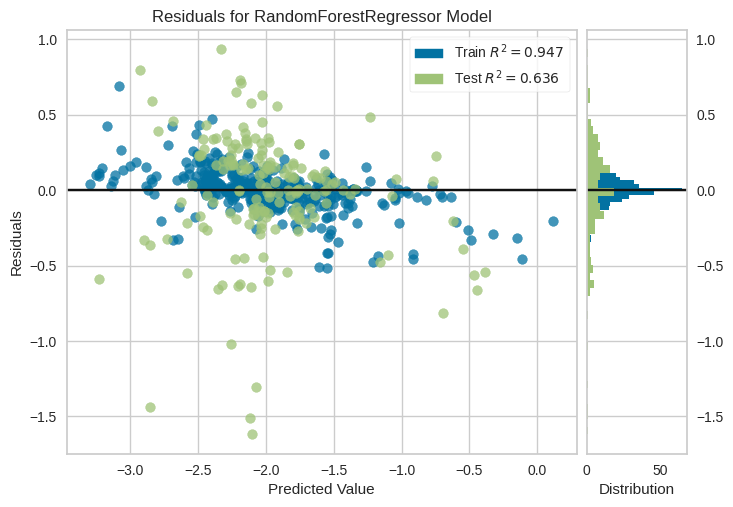

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Gradient Boosting (ECFP)...


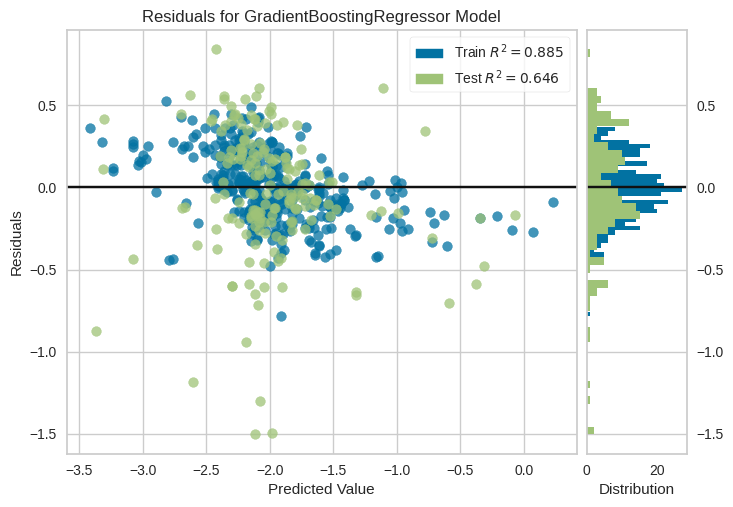

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Decision Tree (ECFP)...


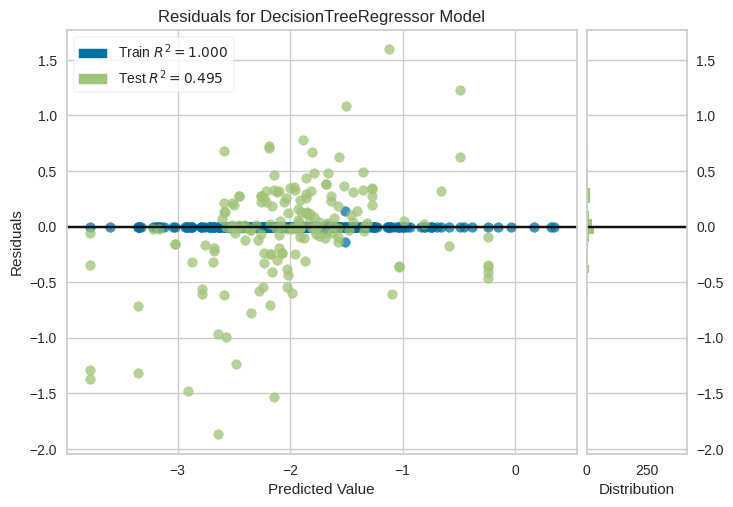

<Figure size 800x550 with 0 Axes>


Visualizing residuals for SVR (ECFP)...


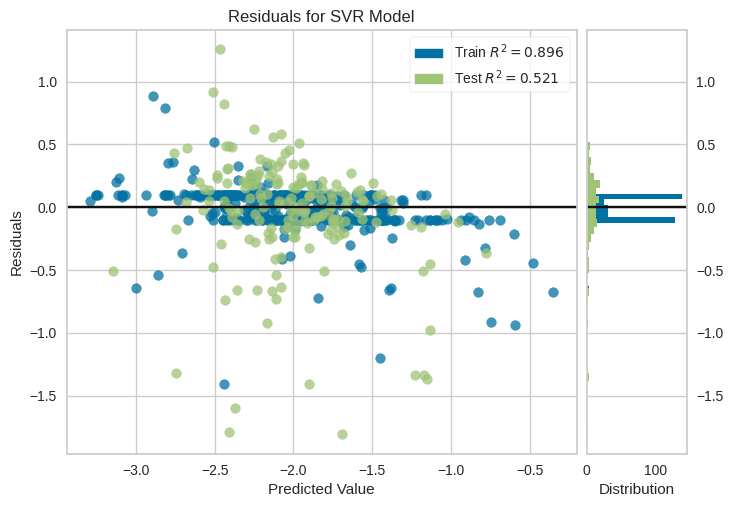

<Figure size 800x550 with 0 Axes>


Visualizing residuals for HistGradientBoostingRegressor (ECFP)...


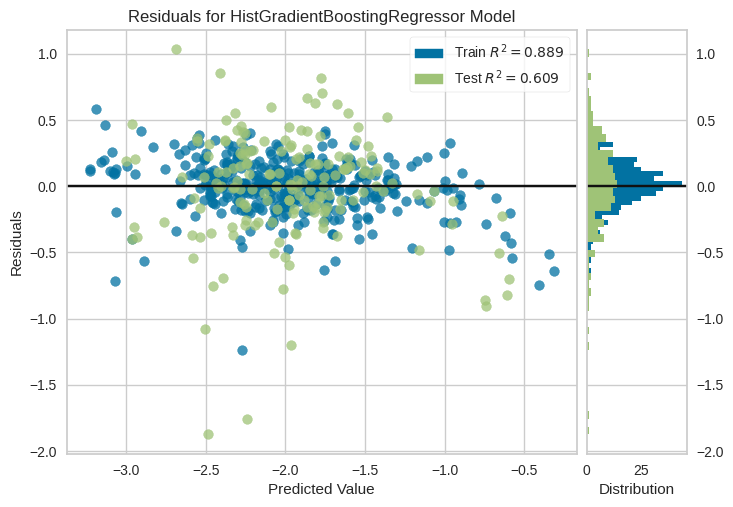

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Linear Regression (MACCS)...


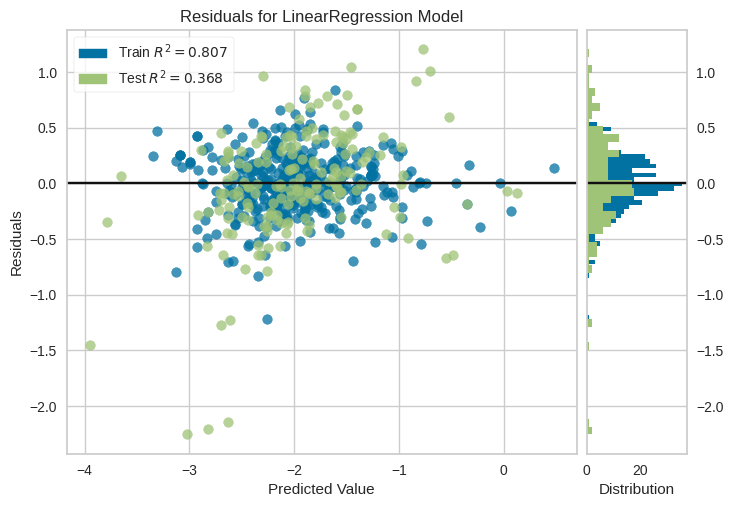

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Ridge Regression (MACCS)...


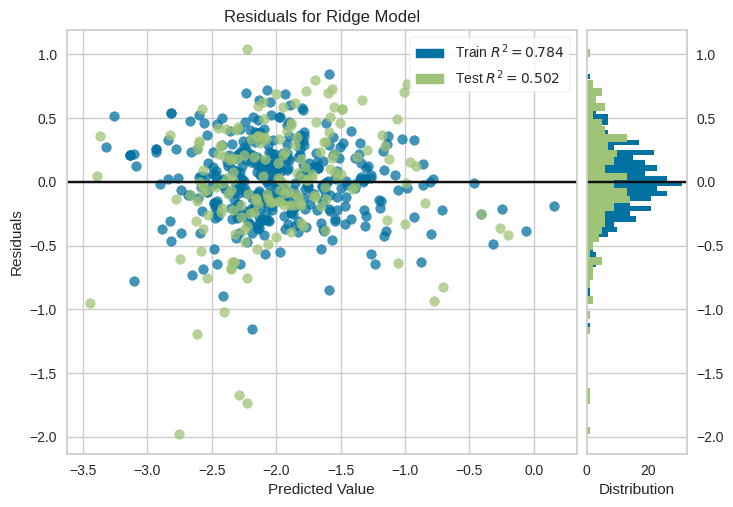

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Lasso Regression (MACCS)...


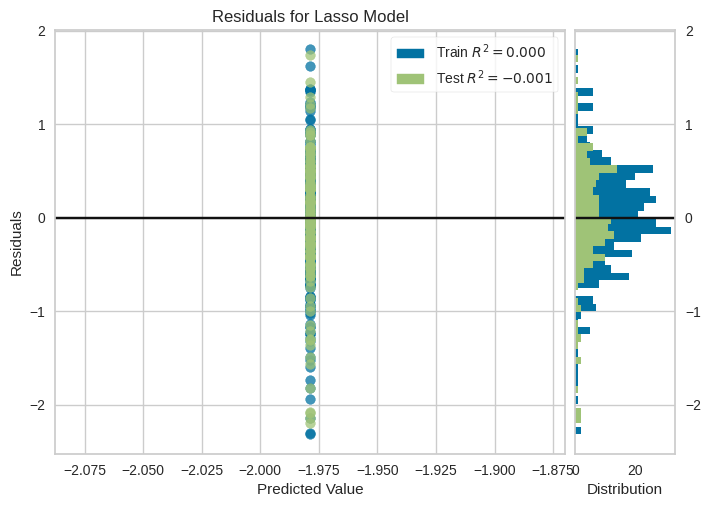

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Elastic Net (MACCS)...


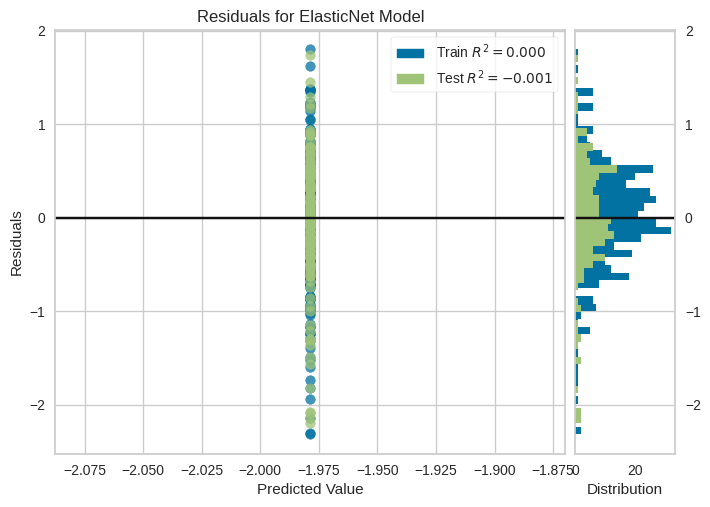

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Random Forest (MACCS)...


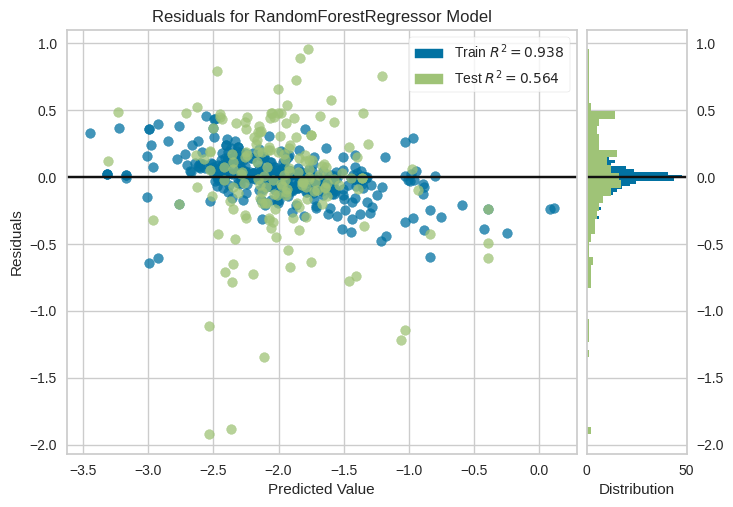

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Gradient Boosting (MACCS)...


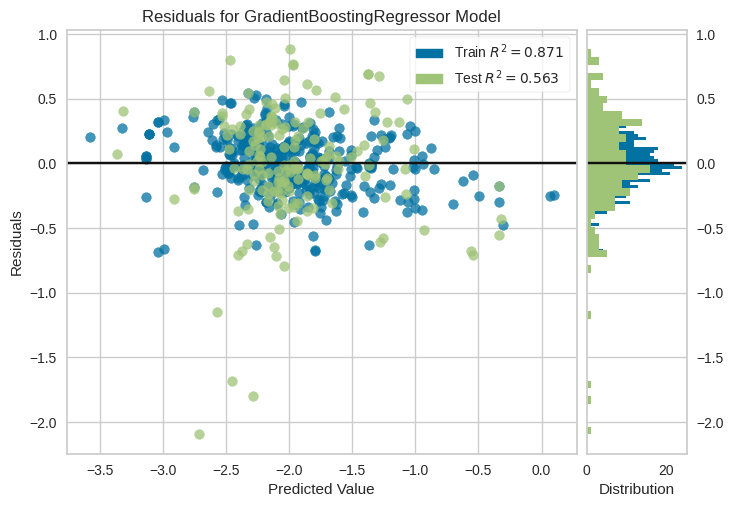

<Figure size 800x550 with 0 Axes>


Visualizing residuals for Decision Tree (MACCS)...


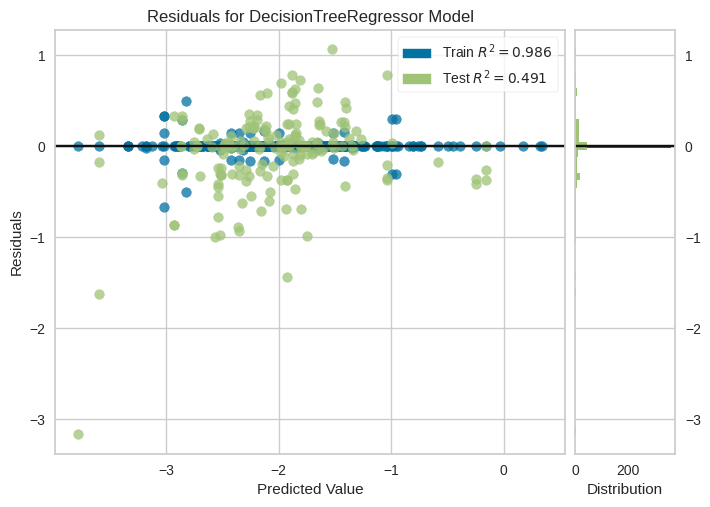

<Figure size 800x550 with 0 Axes>


Visualizing residuals for SVR (MACCS)...


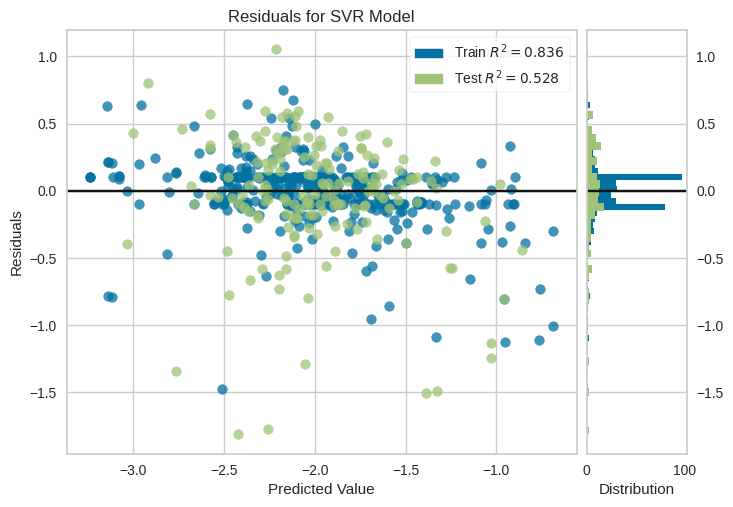

<Figure size 800x550 with 0 Axes>


Visualizing residuals for HistGradientBoostingRegressor (MACCS)...


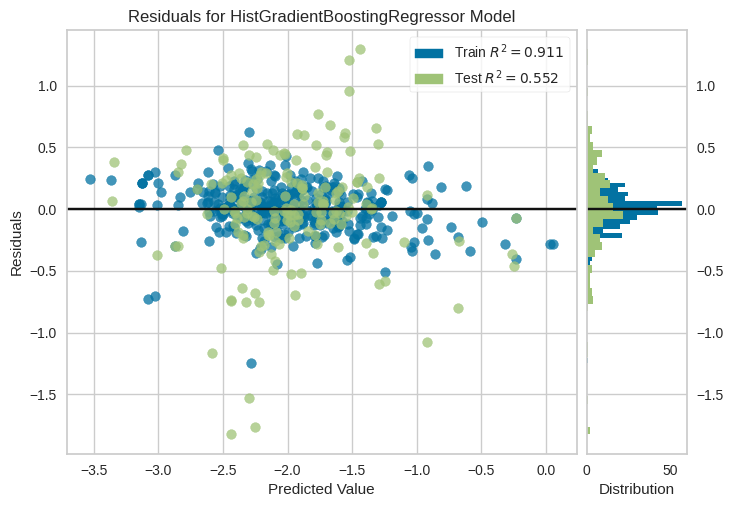

<Figure size 800x550 with 0 Axes>

In [ ]:
# prompt: ahora adapata este codigo para visualizar los resuduos para cada uno de os 8 modelos con los firgerprints elegidos: viz = residuals_plot(model,np.stack(train.fp_maccs), train.pMIC_uM, np.stack(test.fp_maccs), test.pMIC_uM, is_fitted=True)

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from yellowbrick.regressor import prediction_error, residuals_plot
import numpy as np
import pandas as pd

# Assuming 'train' and 'test' DataFrames and 'models' dictionary are defined from the preceding code

# Visualizar los residuales para cada modelo con cada fingerprint
for name, model in models.items():
    print(f"\nVisualizing residuals for {name}...")
    if "(ECFP)" in name:
        # Ensure the model is fitted before visualizing residuals
        model.fit(X_train_ecfp, y_train)
        viz = residuals_plot(model,
                             np.stack(train.fp_ecfp), train.pMIC_uM,
                             np.stack(test.fp_ecfp), test.pMIC_uM,
                             is_fitted=True)
        viz.fig.suptitle(f'Residuals Plot for {name}')
        viz.show()
    elif "(MACCS)" in name:
        # Ensure the model is fitted before visualizing residuals
        model.fit(X_train_maccs, y_train)
        viz = residuals_plot(model,
                             np.stack(train.fp_maccs), train.pMIC_uM,
                             np.stack(test.fp_maccs), test.pMIC_uM,
                             is_fitted=True)
        viz.fig.suptitle(f'Residuals Plot for {name}')
        viz.show()

In [ ]:
# prompt: ahora, mejora los hiperparametros ara el mejor modelo Gradient Boosting (ECFP), que no sean muchas las iteraciones para que no tarde mucho.

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Define the target variable and features
y_train = train.pMIC_uM
y_test = test.pMIC_uM

X_train_ecfp = np.stack(train.fp_ecfp.values)
X_test_ecfp = np.stack(test.fp_ecfp.values)

# Define the parameter grid for Gradient Boosting
# Keeping the number of iterations (n_estimators) relatively low

param_grid = {
    'n_estimators': [50, 80, 100],  # Menos estimadores
    'learning_rate': [0.05, 0.1, 0.15], # Tasa de aprendizaje que converge más rápido
    'max_depth': [2, 3, 4],          # Profundidades de árbol muy pequeñas
    'min_samples_split': [2, 3],     # Ligeramente más restrictivo que solo 2
    'min_samples_leaf': [1, 2],
}
'''param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2],
}
'''
# Initialize the Gradient Boosting Regressor model
gbr = GradientBoostingRegressor(random_state=1)

# Initialize GridSearchCV
# Using n_jobs=-1 to use all available cores for faster computation
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid,
                           scoring='r2', cv=3, n_jobs=-1)

# Perform the grid search on the training data
print("Performing Grid Search for Gradient Boosting (ECFP)...")
grid_search.fit(X_train_ecfp, y_train)

# Get the best parameters and best model
best_params = grid_search.best_params_
best_gbr_model = grid_search.best_estimator_

print("\nBest Hyperparameters for Gradient Boosting (ECFP):")
print(best_params)

# Evaluate the best model on the test set
y_pred_best = best_gbr_model.predict(X_test_ecfp)

mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print("\nEvaluation of the Best Gradient Boosting Model (ECFP):")
print(f"Mean Squared Error (MSE): {mse_best:.4f}")
print(f"R-squared (R2): {r2_best:.4f}")

# You can now use best_gbr_model for predictions and visualization
# For example, you can add it to your 'models' dictionary if needed
# models["Best Gradient Boosting (ECFP)"] = best_gbr_model

# Visualizing the best model (Optional, uncomment to visualize)
# from yellowbrick.regressor import prediction_error, residuals_plot
#
# print("\nVisualizing errors for Best Gradient Boosting (ECFP)...")
# visualizer_best = prediction_error(best_gbr_model,
#                                    X_train=X_train_ecfp, y_train=y_train,
#                                    X_test=X_test_ecfp, y_test=y_test)
# visualizer_best.fig.suptitle('Prediction Error Plot for Best Gradient Boosting (ECFP)')
# visualizer_best.show()
#
# print("\nVisualizing residuals for Best Gradient Boosting (ECFP)...")
# viz_best = residuals_plot(best_gbr_model,
#                           X_train_ecfp, y_train,
#                           X_test_ecfp, y_test,
#                           is_fitted=True)
# viz_best.fig.suptitle('Residuals Plot for Best Gradient Boosting (ECFP)')
# viz_best.show()


Performing Grid Search for Gradient Boosting (ECFP)...

Best Hyperparameters for Gradient Boosting (ECFP):
{'learning_rate': 0.15, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 80}

Evaluation of the Best Gradient Boosting Model (ECFP):
Mean Squared Error (MSE): 0.1446
R-squared (R2): 0.6548


In [ ]:
# prompt: crea este modelo en pickle

import pickle
from sklearn.ensemble import HistGradientBoostingRegressor # Ensure this is imported

# Assuming 'best_gbr_model' is the trained HistGradientBoostingRegressor model you want to pickle

# Define the filename for the pickle file
filename = 'FO_best_gbr_model.pkl'

# Save the model to the file using pickle
with open(filename, 'wb') as file:
    pickle.dump(best_gbr_model, file)

print(f"Model successfully saved to {filename}")

Model successfully saved to FO_best_gbr_model.pkl


In [ ]:
df_for_pred = pd.read_excel('SMILES_paclo.xlsx')
df_for_pred

,NEW_SMILES
0,CC(C)(C(CN1N=NC(C2=CC=CC=C2)=C1)=O)C
1,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=CC=C3)...
2,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=CC=C...
3,CC(C)(C(CN1N=NC(C2CC2)=C1)=O)C
4,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3CC3)=C2)=O)C
...,...
58,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC(C)=C(C...
59,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC(C)=C...
60,CC(C)(C(CN1N=NC(OCC)=C1)=O)C
61,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(OCC)=C2)=O)C


In [ ]:
%%time
with dm.without_rdkit_log():
    df_for_pred['fp_ecfp'] = trans_ecfp.transform(df_for_pred.NEW_SMILES.values)
    df_for_pred['fp_maccs'] = trans_maccs.transform(df_for_pred.NEW_SMILES.values)

print(df_for_pred.shape)
df_for_pred

(63, 3)
CPU times: user 67.1 ms, sys: 1.89 ms, total: 69 ms
Wall time: 69.3 ms


,NEW_SMILES,fp_ecfp,fp_maccs
0,CC(C)(C(CN1N=NC(C2=CC=CC=C2)=C1)=O)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=CC=C3)...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=CC=C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,CC(C)(C(CN1N=NC(C2CC2)=C1)=O)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3CC3)=C2)=O)C,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...
58,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC(C)=C(C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
59,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC(C)=C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
60,CC(C)(C(CN1N=NC(OCC)=C1)=O)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
61,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(OCC)=C2)=O)C,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


,NEW_SMILES,fp_ecfp,fp_maccs,pMIC_uM_pred,ROMol
0,CC(C)(C(CN1N=NC(C2=CC=CC=C2)=C1)=O)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1.978922,
1,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=CC=C3)...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1.754070,
2,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=CC=C...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",-1.754070,

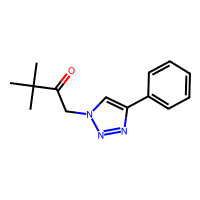
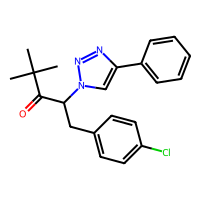
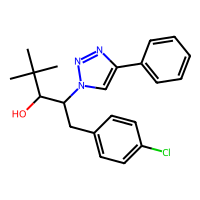

In [ ]:
df_visualization_pred=df_for_pred.copy()
df_visualization_pred['ROMol'] = df_visualization_pred['NEW_SMILES'].apply(Chem.MolFromSmiles)
df_visualization_pred[0:3]


Predictions:


,NEW_SMILES,ROMol,pMIC_uM_pred
0,CC(C)(C(CN1N=NC(C2=CC=CC=C2)=C1)=O)C,,-1.978922
1,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=CC=C3)...,,-1.754070
2,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=CC=C...,,-1.754070
3,CC(C)(C(CN1N=NC(C2CC2)=C1)=O)C,,-1.954419
4,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3CC3)=C2)=O)C,,-1.854578
...,...,...,...
58,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC(C)=C(C...,,-1.665242
59,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC(C)=C...,,-1.665242
60,CC(C)(C(CN1N=NC(OCC)=C1)=O)C,,-1.978922
61,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(OCC)=C2)=O)C,,-1.879081

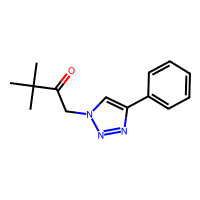
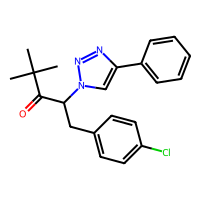
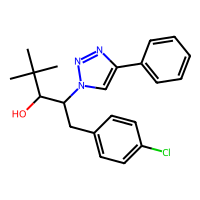
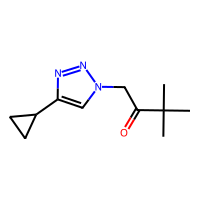
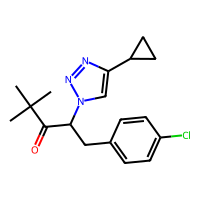
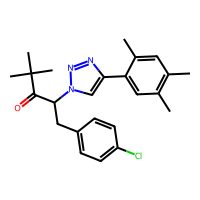
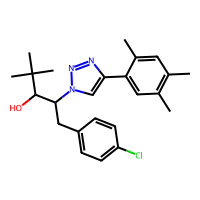
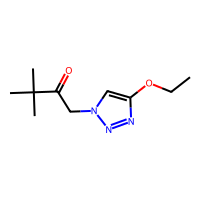
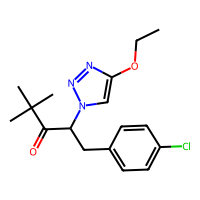
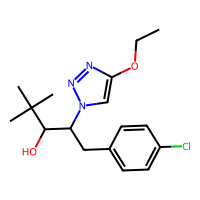

In [ ]:
# prompt: USANDO FO_best_gbr_model.pkl PREDICE LA ACTIVIDAD pMIC_uM_ pred

import numpy as np
import pickle

# Load the model from the pickle file
filename = 'FO_best_gbr_model.pkl'
loaded_model = pickle.load(open(filename, 'rb'))

# Prepare the data for prediction
# Assuming df_for_pred and X_test_ecfp are available from the preceding code
# If you have a new set of molecules for prediction, you would need to
# calculate their ECFP fingerprints similar to how it was done for df_for_pred
X_pred = np.stack(df_visualization_pred.fp_ecfp.values) # Use the calculated fingerprints

# Make predictions
df_visualization_pred['pMIC_uM_pred'] = loaded_model.predict(X_pred)

# Display the results
print("\nPredictions:")
df_visualization_pred[['NEW_SMILES', 'ROMol', 'pMIC_uM_pred']]



Predictions sorted by pMIC_uM_pred (largest to smallest):


,NEW_SMILES,ROMol,pMIC_uM_pred
13,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=C(Br)C...,,-1.027887
14,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=C(Br...,,-1.027887
16,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(CNC(OC(C)(C)...,,-1.072246
17,ClC1=CC=C(CC(C(C(C)(C)C)O)N2C=C(N=N2)CNC(OC(C)...,,-1.072246
15,CC(C)(C(CN1N=NC(CNC(OC(C)(C)C)=O)=C1)=O)C,,-1.200662
...,...,...,...
36,CC(C)(C(CN1N=NC(C2=CC=C(N(C)C)C=C2)=C1)=O)C,,-1.978922
54,CC(C)(C(CN1N=NC(CCO)=C1)=O)C,,-1.978922
60,CC(C)(C(CN1N=NC(OCC)=C1)=O)C,,-1.978922
18,CC(C)(C(CN1N=NC(C2=CC=C(F)C=C2)=C1)=O)C,,-2.078892

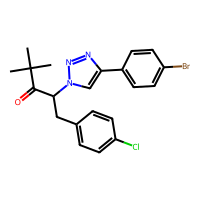
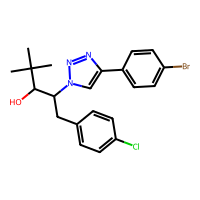
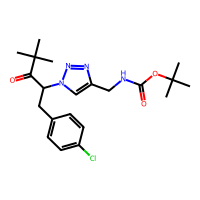
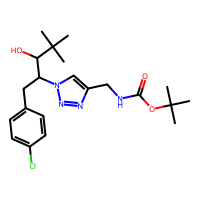
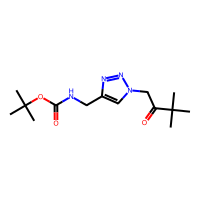
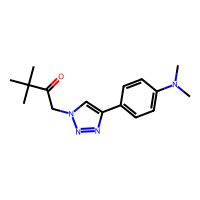
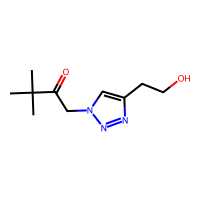
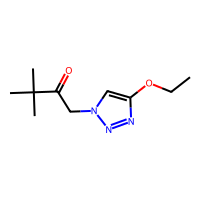
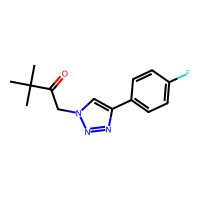
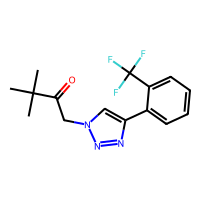

In [ ]:
# prompt: ordena los resultados pMIC_uM_pred mayor a menor

df_visualization_pred_sorted = df_visualization_pred.sort_values(by='pMIC_uM_pred', ascending=False)
print("\nPredictions sorted by pMIC_uM_pred (largest to smallest):")
df_visualization_pred_sorted[['NEW_SMILES', 'ROMol', 'pMIC_uM_pred']]


Predictions with activity classification:


,NEW_SMILES,ROMol,pMIC_uM_pred,activity
0,CC(C)(C(CN1N=NC(C2=CC=CC=C2)=C1)=O)C,,-1.978922,medium
1,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=CC=C3)...,,-1.754070,medium
2,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=CC=C...,,-1.754070,medium
3,CC(C)(C(CN1N=NC(C2CC2)=C1)=O)C,,-1.954419,medium
4,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3CC3)=C2)=O)C,,-1.854578,medium
...,...,...,...,...
58,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC(C)=C(C...,,-1.665242,medium
59,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC(C)=C...,,-1.665242,medium
60,CC(C)(C(CN1N=NC(OCC)=C1)=O)C,,-1.978922,medium
61,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(OCC)=C2)=O)C,,-1.879081,medium

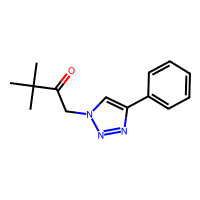
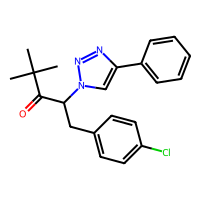
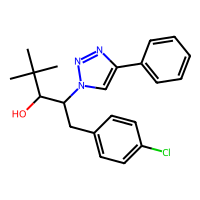
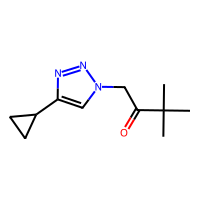
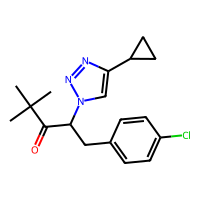
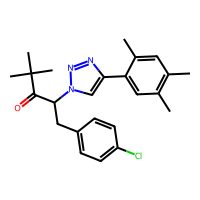
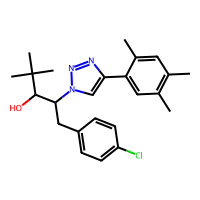
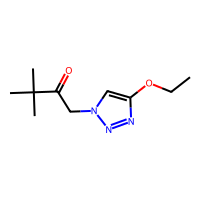
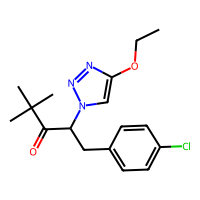
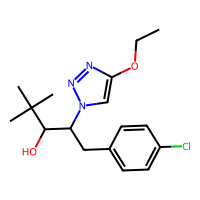

In [ ]:
# prompt: agrega una columna donde, si el valor de pMIC_uM_pred >= -1.65 sea active, si esta entre -1.99 y -1.65 = medium y si es menor a -199 inactivo

def assign_activity(pMIC_pred):
  if pMIC_pred >= -1.65:
    return 'active'
  elif -1.99 < pMIC_pred < -1.65:
    return 'medium'
  else:
    return 'inactive'

df_visualization_pred['activity'] = df_visualization_pred['pMIC_uM_pred'].apply(assign_activity)

# Display the dataframe with the new 'activity' column
print("\nPredictions with activity classification:")
df_visualization_pred[['NEW_SMILES', 'ROMol', 'pMIC_uM_pred', 'activity']]



Predictions sorted by pMIC_uM_pred (largest to smallest):


,NEW_SMILES,ROMol,pMIC_uM_pred,activity
13,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=C(Br)C...,,-1.027887,active
14,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=C(Br...,,-1.027887,active
16,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(CNC(OC(C)(C)...,,-1.072246,active
17,ClC1=CC=C(CC(C(C(C)(C)C)O)N2C=C(N=N2)CNC(OC(C)...,,-1.072246,active
15,CC(C)(C(CN1N=NC(CNC(OC(C)(C)C)=O)=C1)=O)C,,-1.200662,active
...,...,...,...,...
36,CC(C)(C(CN1N=NC(C2=CC=C(N(C)C)C=C2)=C1)=O)C,,-1.978922,medium
54,CC(C)(C(CN1N=NC(CCO)=C1)=O)C,,-1.978922,medium
60,CC(C)(C(CN1N=NC(OCC)=C1)=O)C,,-1.978922,medium
18,CC(C)(C(CN1N=NC(C2=CC=C(F)C=C2)=C1)=O)C,,-2.078892,inactive

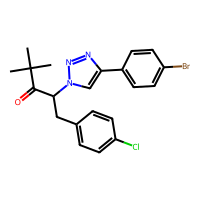
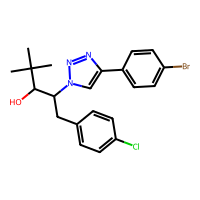
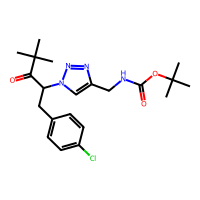
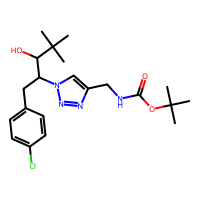
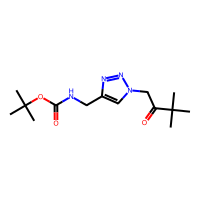
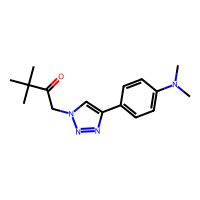
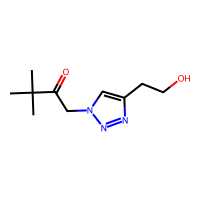
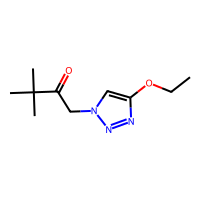
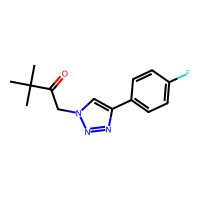
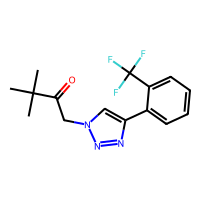

In [ ]:
df_visualization_pred_sorted = df_visualization_pred.sort_values(by='pMIC_uM_pred', ascending=False)
print("\nPredictions sorted by pMIC_uM_pred (largest to smallest):")
df_visualization_pred_sorted[['NEW_SMILES', 'ROMol', 'pMIC_uM_pred', 'activity']]

,NEW_SMILES,ROMol,pMIC_uM_pred,activity
13,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=C(Br)C...,,-1.027887,active
14,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC=C(Br...,,-1.027887,active
16,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(CNC(OC(C)(C)...,,-1.072246,active
17,ClC1=CC=C(CC(C(C(C)(C)C)O)N2C=C(N=N2)CNC(OC(C)...,,-1.072246,active
15,CC(C)(C(CN1N=NC(CNC(OC(C)(C)C)=O)=C1)=O)C,,-1.200662,active
12,CC(C)(C(CN1N=NC(C2=CC=C(Br)C=C2)=C1)=O)C,,-1.221094,active
31,CC(C)(C(C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC(C=CC(O...,,-1.659082,medium
32,CC(C)(C(O)C(CC(C=C1)=CC=C1Cl)N2N=NC(C3=CC(C=CC...,,-1.659082,medium

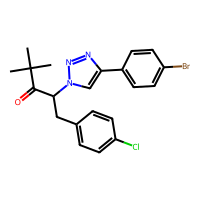
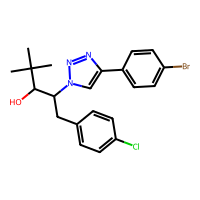
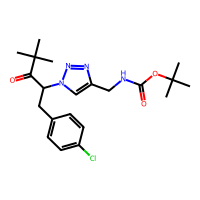
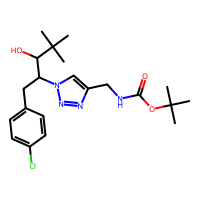
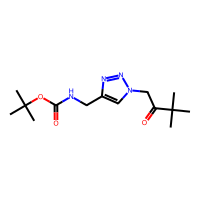
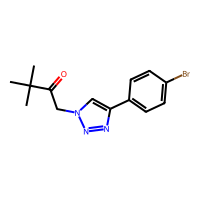
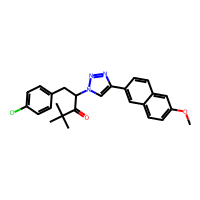
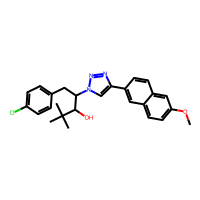

In [ ]:
FO_pred = df_visualization_pred_sorted[['NEW_SMILES', 'ROMol', 'pMIC_uM_pred', 'activity']]
FO_pred[:8]

In [ ]:
FO_pred['activity'].value_counts()

,count
activity,
medium,55
active,6
inactive,2


In [ ]:
FO_pred.to_csv('FO_pred.csv', index=False)

<a name='7'></a>

##**7.** Construcción y visualización del modelo.
Usa [YellowBrick](https://www.scikit-yb.org/en/latest/) para construir el modelo y visualizar su empeño. La **perdida** reportada en el gráfico siguiente es la [$R^2$](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.r2_score.html) para el modelo.

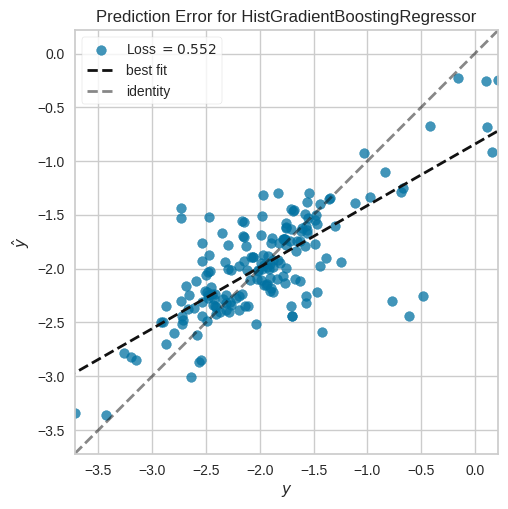

CPU times: user 154 ms, sys: 2.86 ms, total: 157 ms
Wall time: 157 ms


In [ ]:
%%time
visualizer = prediction_error(model,
                              X_train=np.stack(train.fp_maccs), y_train=train.pMIC_uM,
                              X_test=np.stack(test.fp_maccs), y_test=test.pMIC_uM)

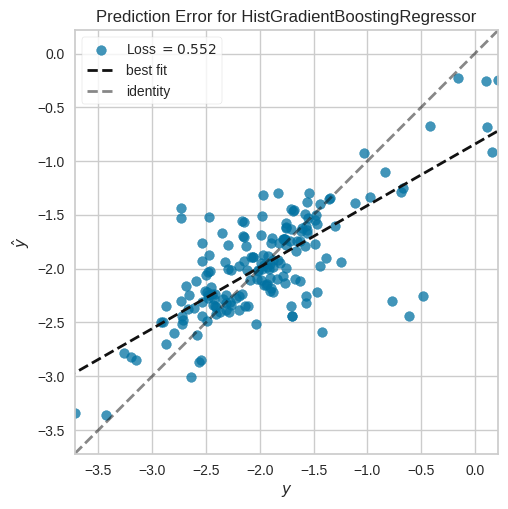

CPU times: user 148 ms, sys: 643 µs, total: 149 ms
Wall time: 148 ms


In [ ]:
%%time
visualizer = prediction_error(model,
                              X_train=np.stack(train.fp_maccs), y_train=train.pMIC_uM,
                              X_test=np.stack(test.fp_maccs), y_test=test.pMIC_uM)

Un R2 de X indica que el modelo explica aproximadamente el X% de la variabilidad en la variable objetivo en el conjunto de prueba. Esto se considera 1) bastante bueno (al ser alto) y sugiere que el modelo tiene un buen poder predictivo. 2) malo (al ser bajo) y sugiere que el modelo tiene un mal poder predictivo

<a name='8'></a>
##**8.** Residuales.
Gráfica los residuales del set de entrenamiento y prueba. Los residuales son la diferencia entre los valores reales de la variable objetivo y las predicciones realizadas por el modelo. Los residuales son una medida de cuánto se desvían las predicciones del modelo de los valores reales. Si un modelo es preciso, los residuales deberían ser cercanos a cero.
Una gran diferencia entre la R2 de entrenamiento y prueba podría indicar sobreajuste (overfitting), donde el modelo se ha adaptado demasiado a los datos de entrenamiento específicos y no generaliza bien a nuevos datos.

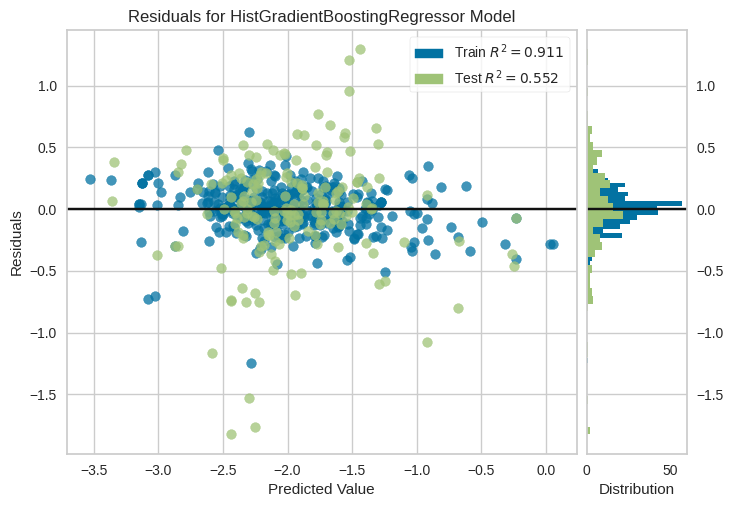

In [ ]:
viz = residuals_plot(model,np.stack(train.fp_maccs), train.pMIC_uM, np.stack(test.fp_maccs), test.pMIC_uM, is_fitted=True)